# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

Matplotlib is building the font cache; this may take a moment.


In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 90.5%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Done.


## Loading raw files and reading them as training and testing datasets

In [3]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

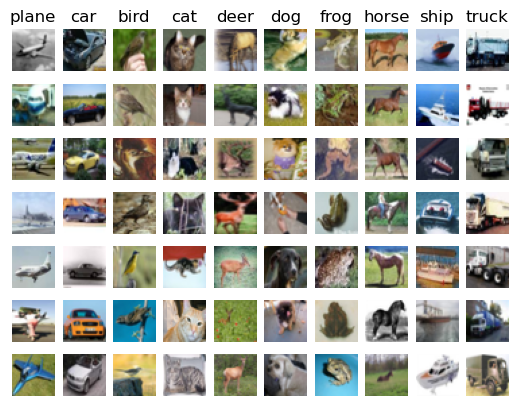

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [5]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images. 
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

#### 1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images.

In [7]:
#Let us look at our training data. 
X_train

array([[ 59.,  62.,  63., ..., 123.,  92.,  72.],
       [154., 177., 187., ..., 143., 133., 144.],
       [255., 255., 255., ...,  80.,  86.,  84.],
       ...,
       [164., 172., 182., ..., 140., 143., 158.],
       [206., 164., 142., ..., 179., 144., 141.],
       [109., 174., 224., ..., 118., 141., 158.]])

##### Observations: 
* Each image is stored as an array of pixel values. 
* So, the range of values possible is 0 to 255. 
* Let us scale these values in order to decrease computational load on our model. 

In [8]:
from sklearn.preprocessing import StandardScaler

# scaling our values using standardScaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Let us look at our scaled data.
X_train_scaled

array([[-1.02122047, -1.03719909, -0.88678485, ..., -0.07765246,
        -0.56405535, -0.65219521],
       [ 0.28128671,  0.53328011,  0.64569168, ...,  0.24216823,
         0.11596904,  0.4781802 ],
       [ 1.6660575 ,  1.5984747 ,  1.48608204, ..., -0.76526696,
        -0.66357111, -0.46379931],
       ...,
       [ 0.41839273,  0.46499841,  0.58389828, ...,  0.19419513,
         0.28182864,  0.69797542],
       [ 0.99423801,  0.35574768,  0.08955101, ...,  0.81784548,
         0.2984146 ,  0.43108122],
       [-0.33569038,  0.49231109,  1.10296291, ..., -0.15760764,
         0.24865672,  0.69797542]])

#### Model

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Initially trying with 5 nearest neighbors. 
k = 5  
knn_model = KNeighborsClassifier(n_neighbors=k)

# Training the model with our scaled data.
knn_model.fit(X_train_scaled, y_train)

# testing our model
y_pred = knn_model.predict(X_test_scaled)

In [12]:
#Our model predictions are as follows
y_pred

array([4, 0, 8, 0, 4, 6, 6, 4, 2, 0, 8, 6, 4, 6, 4, 4, 3, 3, 0, 3, 2, 0,
       2, 4, 2, 6, 4, 8, 4, 4, 4, 4, 3, 4, 8, 0, 4, 8, 8, 4, 0, 4, 4, 4,
       8, 2, 4, 4, 4, 4, 8, 2, 6, 4, 1, 8, 0, 6, 2, 4, 2, 4, 4, 0, 6, 4,
       1, 0, 4, 8, 2, 4, 0, 8, 0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 0, 8, 5, 8,
       0, 8, 8, 4, 8, 2, 4, 4, 4, 8, 0, 3, 0, 4, 6, 3, 6, 0, 4, 4, 3, 3,
       4, 2, 2, 4, 6, 6, 0, 8, 4, 4, 0, 4, 2, 5, 8, 4, 2, 3, 4, 2, 2, 0,
       8, 3, 0, 0, 8, 0, 6, 8, 2, 0, 2, 4, 9, 2, 6, 6, 3, 3, 0, 1, 2, 2,
       0, 4, 2, 8, 4, 4, 2, 6, 2, 4, 0, 8, 0, 4, 0, 0, 0, 0, 2, 8, 4, 9,
       0, 4, 4, 8, 0, 0, 2, 4, 2, 4, 4, 0, 0, 8, 2, 0, 4, 6, 4, 4, 2, 0,
       4, 2, 2, 0, 8, 4, 4, 2, 0, 2, 2, 8, 2, 8, 2, 8, 2, 0, 0, 9, 0, 4,
       3, 4, 8, 4, 2, 2, 2, 2, 2, 4, 4, 3, 4, 4, 8, 0, 4, 0, 0, 2, 5, 8,
       0, 8, 8, 3, 2, 8, 4, 4])

In [13]:
#Actual classes are as follows.
y_test

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2,
       1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
       8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7,
       4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1,
       8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0,
       0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9,
       3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8,
       7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2,
       7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1,
       8, 9, 0, 3, 1, 9, 2, 2])

In [14]:
from sklearn.metrics import accuracy_score

# Evaluating our model performance using accuracy.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.176


##### Observations: 
* We have created a very poor model, with an accuracy of only 17.6%
* It might be because, the process we are following, differences between respective pixels of different images is not a great factor in ideftifying neighborhood classes. 
* However, let us try an improve this model by trying different distance algorithms and different k values. 

##### 2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.

In [15]:
#since we have only 500 trainging images, it would be beneficial to have high folds. 
folds = 10

In [16]:
from sklearn.model_selection import KFold

# Initializing K-Fold Cross-Validation with 10 folds
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

In [17]:
from sklearn.model_selection import cross_val_score

# Running cross-validation
cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=kf)

In [18]:
cv_scores

array([0.16, 0.2 , 0.1 , 0.1 , 0.16, 0.22, 0.22, 0.28, 0.24, 0.26])

In [19]:
np.mean(cv_scores)

0.194

#### Observations: 
* The above KFold Cross Validation is for KNN model with 5 nearest neighbors. 
* We have got a mean accuracy of 19.4%, which is better than previous 17.6% accuracy. 
* Now let us try with different n_neighbors values, weights and distance algorithms. 

In [22]:
#Defining our metrics possible values. 

#n_neighbors 
# we prefer odd numbers for our n_neighbors values to avoid equal class problems.
nn_values = [1,3,5,7,9,11,13,15,17,19,21,31,51,101]

#weights
# Uniform - treats all neighbors as equals. 
# Distance - gives importance to nearest neighbor. 
w_values = ['uniform', 'distance'] 

#distance algorithms - P 
# 1 - Manhattan Distance
# 2 - Euclidean Distance
# 3 - Minkowski Distance
p_values = [1,2,3]

In [23]:
# Dictionary to store mean cross-validation scores for each combination of attributes. 
cv_scores_dict = {}

In [24]:
# Iterate over different attribute values combinations. 
for w in w_values:
    for n in nn_values:
        for p in p_values:
            
            #Initializing our KNN algorithm with combination of attributes. 
            knn_cv_model = KNeighborsClassifier(n_neighbors=n, weights=w, p=p)
            
            #Calculating scores. 
            scores = cross_val_score(knn_cv_model, X_train_scaled, y_train, cv=kf)
            cv_scores_dict[(n, w, p)] = np.mean(scores)
            print(f"n = {n}, w = {w}, p = {p}, Cross-validation scores: {scores}, Mean score: {np.mean(scores)}")


n = 1, w = uniform, p = 1, Cross-validation scores: [0.24 0.24 0.18 0.14 0.28 0.32 0.3  0.2  0.24 0.32], Mean score: 0.246
n = 1, w = uniform, p = 2, Cross-validation scores: [0.26 0.3  0.22 0.24 0.3  0.28 0.26 0.28 0.24 0.3 ], Mean score: 0.26799999999999996
n = 1, w = uniform, p = 3, Cross-validation scores: [0.24 0.24 0.18 0.12 0.24 0.28 0.26 0.28 0.14 0.24], Mean score: 0.22199999999999998
n = 3, w = uniform, p = 1, Cross-validation scores: [0.32 0.28 0.2  0.18 0.2  0.28 0.2  0.16 0.3  0.3 ], Mean score: 0.242
n = 3, w = uniform, p = 2, Cross-validation scores: [0.22 0.2  0.16 0.16 0.14 0.26 0.2  0.26 0.26 0.26], Mean score: 0.21200000000000002
n = 3, w = uniform, p = 3, Cross-validation scores: [0.16 0.28 0.16 0.16 0.12 0.24 0.22 0.24 0.22 0.18], Mean score: 0.198
n = 5, w = uniform, p = 1, Cross-validation scores: [0.26 0.34 0.16 0.16 0.18 0.28 0.24 0.22 0.3  0.32], Mean score: 0.246
n = 5, w = uniform, p = 2, Cross-validation scores: [0.16 0.2  0.1  0.1  0.16 0.22 0.22 0.28 0.24

n = 13, w = distance, p = 3, Cross-validation scores: [0.2  0.28 0.12 0.18 0.2  0.24 0.2  0.32 0.24 0.26], Mean score: 0.22400000000000003
n = 15, w = distance, p = 1, Cross-validation scores: [0.24 0.3  0.18 0.18 0.18 0.26 0.22 0.24 0.28 0.28], Mean score: 0.23600000000000004
n = 15, w = distance, p = 2, Cross-validation scores: [0.2  0.3  0.1  0.2  0.22 0.28 0.22 0.3  0.28 0.24], Mean score: 0.23399999999999999
n = 15, w = distance, p = 3, Cross-validation scores: [0.18 0.32 0.12 0.16 0.18 0.22 0.22 0.26 0.18 0.2 ], Mean score: 0.20400000000000001
n = 17, w = distance, p = 1, Cross-validation scores: [0.2  0.32 0.16 0.16 0.24 0.34 0.22 0.26 0.34 0.3 ], Mean score: 0.254
n = 17, w = distance, p = 2, Cross-validation scores: [0.2  0.3  0.14 0.18 0.2  0.26 0.2  0.24 0.28 0.24], Mean score: 0.22400000000000003
n = 17, w = distance, p = 3, Cross-validation scores: [0.14 0.3  0.12 0.16 0.16 0.22 0.2  0.26 0.22 0.26], Mean score: 0.20400000000000001
n = 19, w = distance, p = 1, Cross-valida

In [25]:
# Finding the best combination of attributes. 
best_nwp = max(cv_scores_dict, key=cv_scores_dict.get)
best_accuracy_score = cv_scores_dict[best_nwp]

print(f"\nBest (n, w, p) combination: n = {best_nwp[0]}, w = {best_nwp[1]}, p = {best_nwp[2]}")
print(f"Best cross-validation score: {best_accuracy_score}")


Best (n, w, p) combination: n = 1, w = uniform, p = 2
Best cross-validation score: 0.26799999999999996


##### Observations: 
* Even after trying different attributes, the best we could get using Knn Algorithm is 26.7% 
* Let us visualize these scores through graphs, and see if we can find anything to improve. 

###### Visulaizations

In [43]:
# Converting the dictionary to a DataFrame for easier manipulation
import pandas as pd
cv_scores_df = pd.DataFrame(cv_scores_dict.items(), columns=['Params', 'Mean Score'])
cv_scores_df[['n_neighbors', 'weights', 'p']] = pd.DataFrame(cv_scores_df['Params'].tolist(), index=cv_scores_df.index)
cv_scores_df.drop('Params', axis=1, inplace=True)

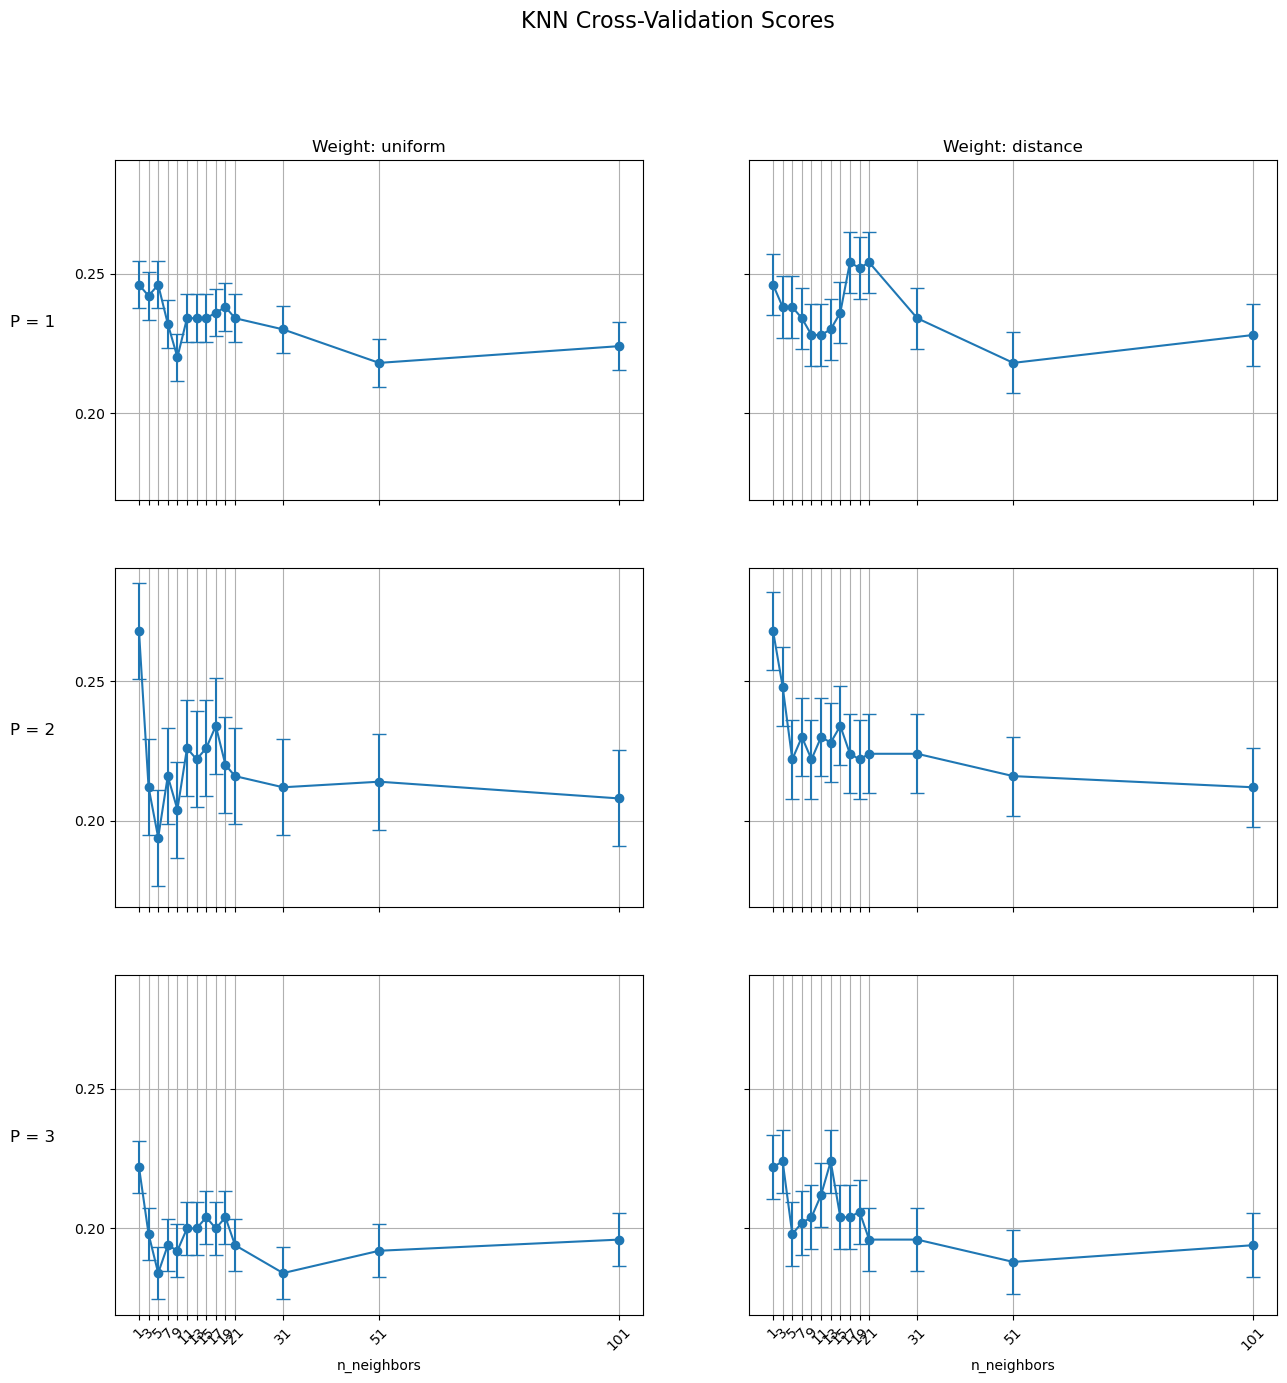

In [56]:
# Create a plot for each combination of weights and p values
fig, axes = plt.subplots(len(p_values), len(w_values), figsize=(15, 15), sharey=True, sharex=True)
fig.suptitle('KNN Cross-Validation Scores', fontsize=16)

# Set column and row labels
for ax, col in zip(axes[0], w_values):
    ax.set_title(f'Weight: {col}', fontsize=12)
for ax, row in zip(axes[:, 0], p_values):
    ax.set_ylabel(f'P = {row}', rotation=0, size='large', labelpad=30)
    
# Plotting data and axis labels
for i, p in enumerate(p_values):
    for j, weight in enumerate(w_values):
        ax = axes[i, j]
        
        #Creating a subset of data according to our combination plot. 
        subset = cv_scores_df[(cv_scores_df['weights'] == weight) & (cv_scores_df['p'] == p)]
        
        # Sorting by n_neighbors to plot correctly
        subset = subset.sort_values(by='n_neighbors')
        
        #plotting trend line with error bars 
        ax.errorbar(subset['n_neighbors'], subset['Mean Score'], yerr=subset['Mean Score'].std(), fmt='-o', capsize=5)
        ax.grid(True)

        if i == len(p_values) - 1:
            ax.set_xlabel('n_neighbors')
            
        # Set x and y ticks
        ax.set_xticks(subset['n_neighbors'])
        ax.set_xticklabels(subset['n_neighbors'], rotation=45)
        ax.set_yticks(np.arange(0.2, 0.3, 0.05))  # Adjusted to 0 to 0.3 range

plt.show()